### HW2 Prudnikov

Для скачивания подграфа я использовал scrapy project и делал это из ide, поэтому тут приведу только код settings.py, items.py и spider.py, запускался проект из ide через командную строку (полный проект можно посмотреть и запустить из https://github.com/EvgeniyPrudnikov/Magistracy/tree/master/IR/hw2/hw2_wiki)
результаты работы бота сохранялись в файле в json формате.
url, title, snippet - описание посещенной вершины, linked_urls - ссылки на другие страницы

In [ ]:
# ------------------------------------------------------------
# settings.py
# ------------------------------------------------------------
# -*- coding: utf-8 -*-
# Scrapy settings for hw2_wiki project
BOT_NAME = 'hw2_wiki'

SPIDER_MODULES = ['hw2_wiki.spiders']
NEWSPIDER_MODULE = 'hw2_wiki.spiders'
FEED_FORMAT="jsonlines"
# ------------------------------------------------------------
# файл, в который сохраняются результаты
# ------------------------------------------------------------
FEED_URI="sitegraph.json"
# ------------------------------------------------------------
# ------------------------------------------------------------
# бот останавливается после посещения ~10000 страниц
# ------------------------------------------------------------
CLOSESPIDER_PAGECOUNT = 10000
# ---------------------------------------------------
# Obey robots.txt rules
ROBOTSTXT_OBEY = True

# ------------------------------------------------------------
# items.py
# ------------------------------------------------------------

# -*- coding: utf-8 -*-

# Define here the models for your scraped items
import scrapy
class WikiItem(scrapy.Item):
    url = scrapy.Field()
    title = scrapy.Field()
    snippet = scrapy.Field()
    linked_urls = scrapy.Field()

# ------------------------------------------------------------
# wiki_spider.py
# ------------------------------------------------------------

# -*- coding: utf-8 -*-
import scrapy
from hw2_wiki.items import WikiItem
from bs4 import BeautifulSoup
import re

class WikiSpider(scrapy.Spider):
    name = 'wiki_spider'
    start_urls = ['https://en.wikipedia.org/wiki/Minsk',
                  'https://en.wikipedia.org/wiki/Australia',
                  'https://en.wikipedia.org/wiki/United_States',
                  'https://en.wikipedia.org/wiki/Russia']

    visited_urls = set()
    header_selector = 'h1#firstHeading.firstHeading::text'
    body_link_selector = '(//div[@id="mw-content-text"]/p/a/@href)[position() < 100]'

    allowed_re = re.compile('https://.+.wikipedia\.org/wiki/'
                            '(?!((File|Talk|Category|Portal|Special|'
                            'Template|Template_talk|Wikipedia|Help|Draft):|Main_Page)).+')

    def parse(self, response):

        item = WikiItem()
        item['title'] = response.css(self.header_selector).extract_first()
        item['url'] = response.url

        item['snippet'] = BeautifulSoup(response.xpath('//div[ @ id = "mw-content-text"] / p[1]').extract_first(),
                                        'lxml').get_text()[:255].encode('utf-8') + '...'

        linked_links = [response.urljoin(link) for link in response.xpath(self.body_link_selector).extract() if
                        link[0] != '#']
        # сохраняем ссылки на след страницы
        item['linked_urls'] = linked_links

        yield item

        self.visited_urls.add(response.url)
        # переходим по сохраненным ссылкам
        for next_url in linked_links:
            if self.allowed_re.match(next_url) and next_url not in self.visited_urls:
                yield scrapy.Request(next_url, callback=self.parse)
        # бот обойдет не все ссылки, и остановиться по условию CLOSESPIDER_PAGECOUNT = 10000 => 
        # у последних уровней останутся ссылки в linked_urls, о которых нет никакой информации (titlt, snippet)


Дальнейшая работа с результатами:

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt 
import math

In [2]:
# файл бота из предыдущего шага
file_name = './hw2_wiki/spiders/sitegraph.json'

Открываем файл со скачанными ссылками и читаем его в pandas dataframe, для удобства дальнейшей работы:

In [3]:
def load_df(file_name):
    with open(file_name, 'rb') as f:
        data = f.readlines()
    # магия для чтения json в pandas dataframe:
    #--------------------------------------------------
    data = map(lambda x: x.rstrip(), data)
    data_json_str = "[" + ','.join(data) + "]"
    #--------------------------------------------------
    main_df = pd.read_json(data_json_str)
    main_df['url'] = main_df['url'].astype(basestring).map(lambda x : x.strip())
    # посмотрим что получилось:
    main_df.head()
    return main_df

main_df = load_df(file_name)

Создаем граф:
так как бот не успел обойти все ссылки, то на поседних уровнях вершины будут ссылаться на страницы, о которых нет информации => их нужно отфильтровать

In [6]:
def create_graph(df, ratio=1):
    # для рисования графа (возьмем 2%)
    num_rows = int(math.ceil(ratio * main_df['url'].shape[0]))
    dg = nx.DiGraph()
    edges = [ (i[0], j) for i in zip(main_df['url'], main_df['linked_urls'])[:num_rows] for j in i[1] if j in main_df['url'].tolist()]
    dg.add_edges_from(edges)
    print 'number of nodes: ', dg.number_of_nodes()
    print 'number of edges: ', dg.number_of_edges()
    return dg

Как примерно будет выглядеть граф:

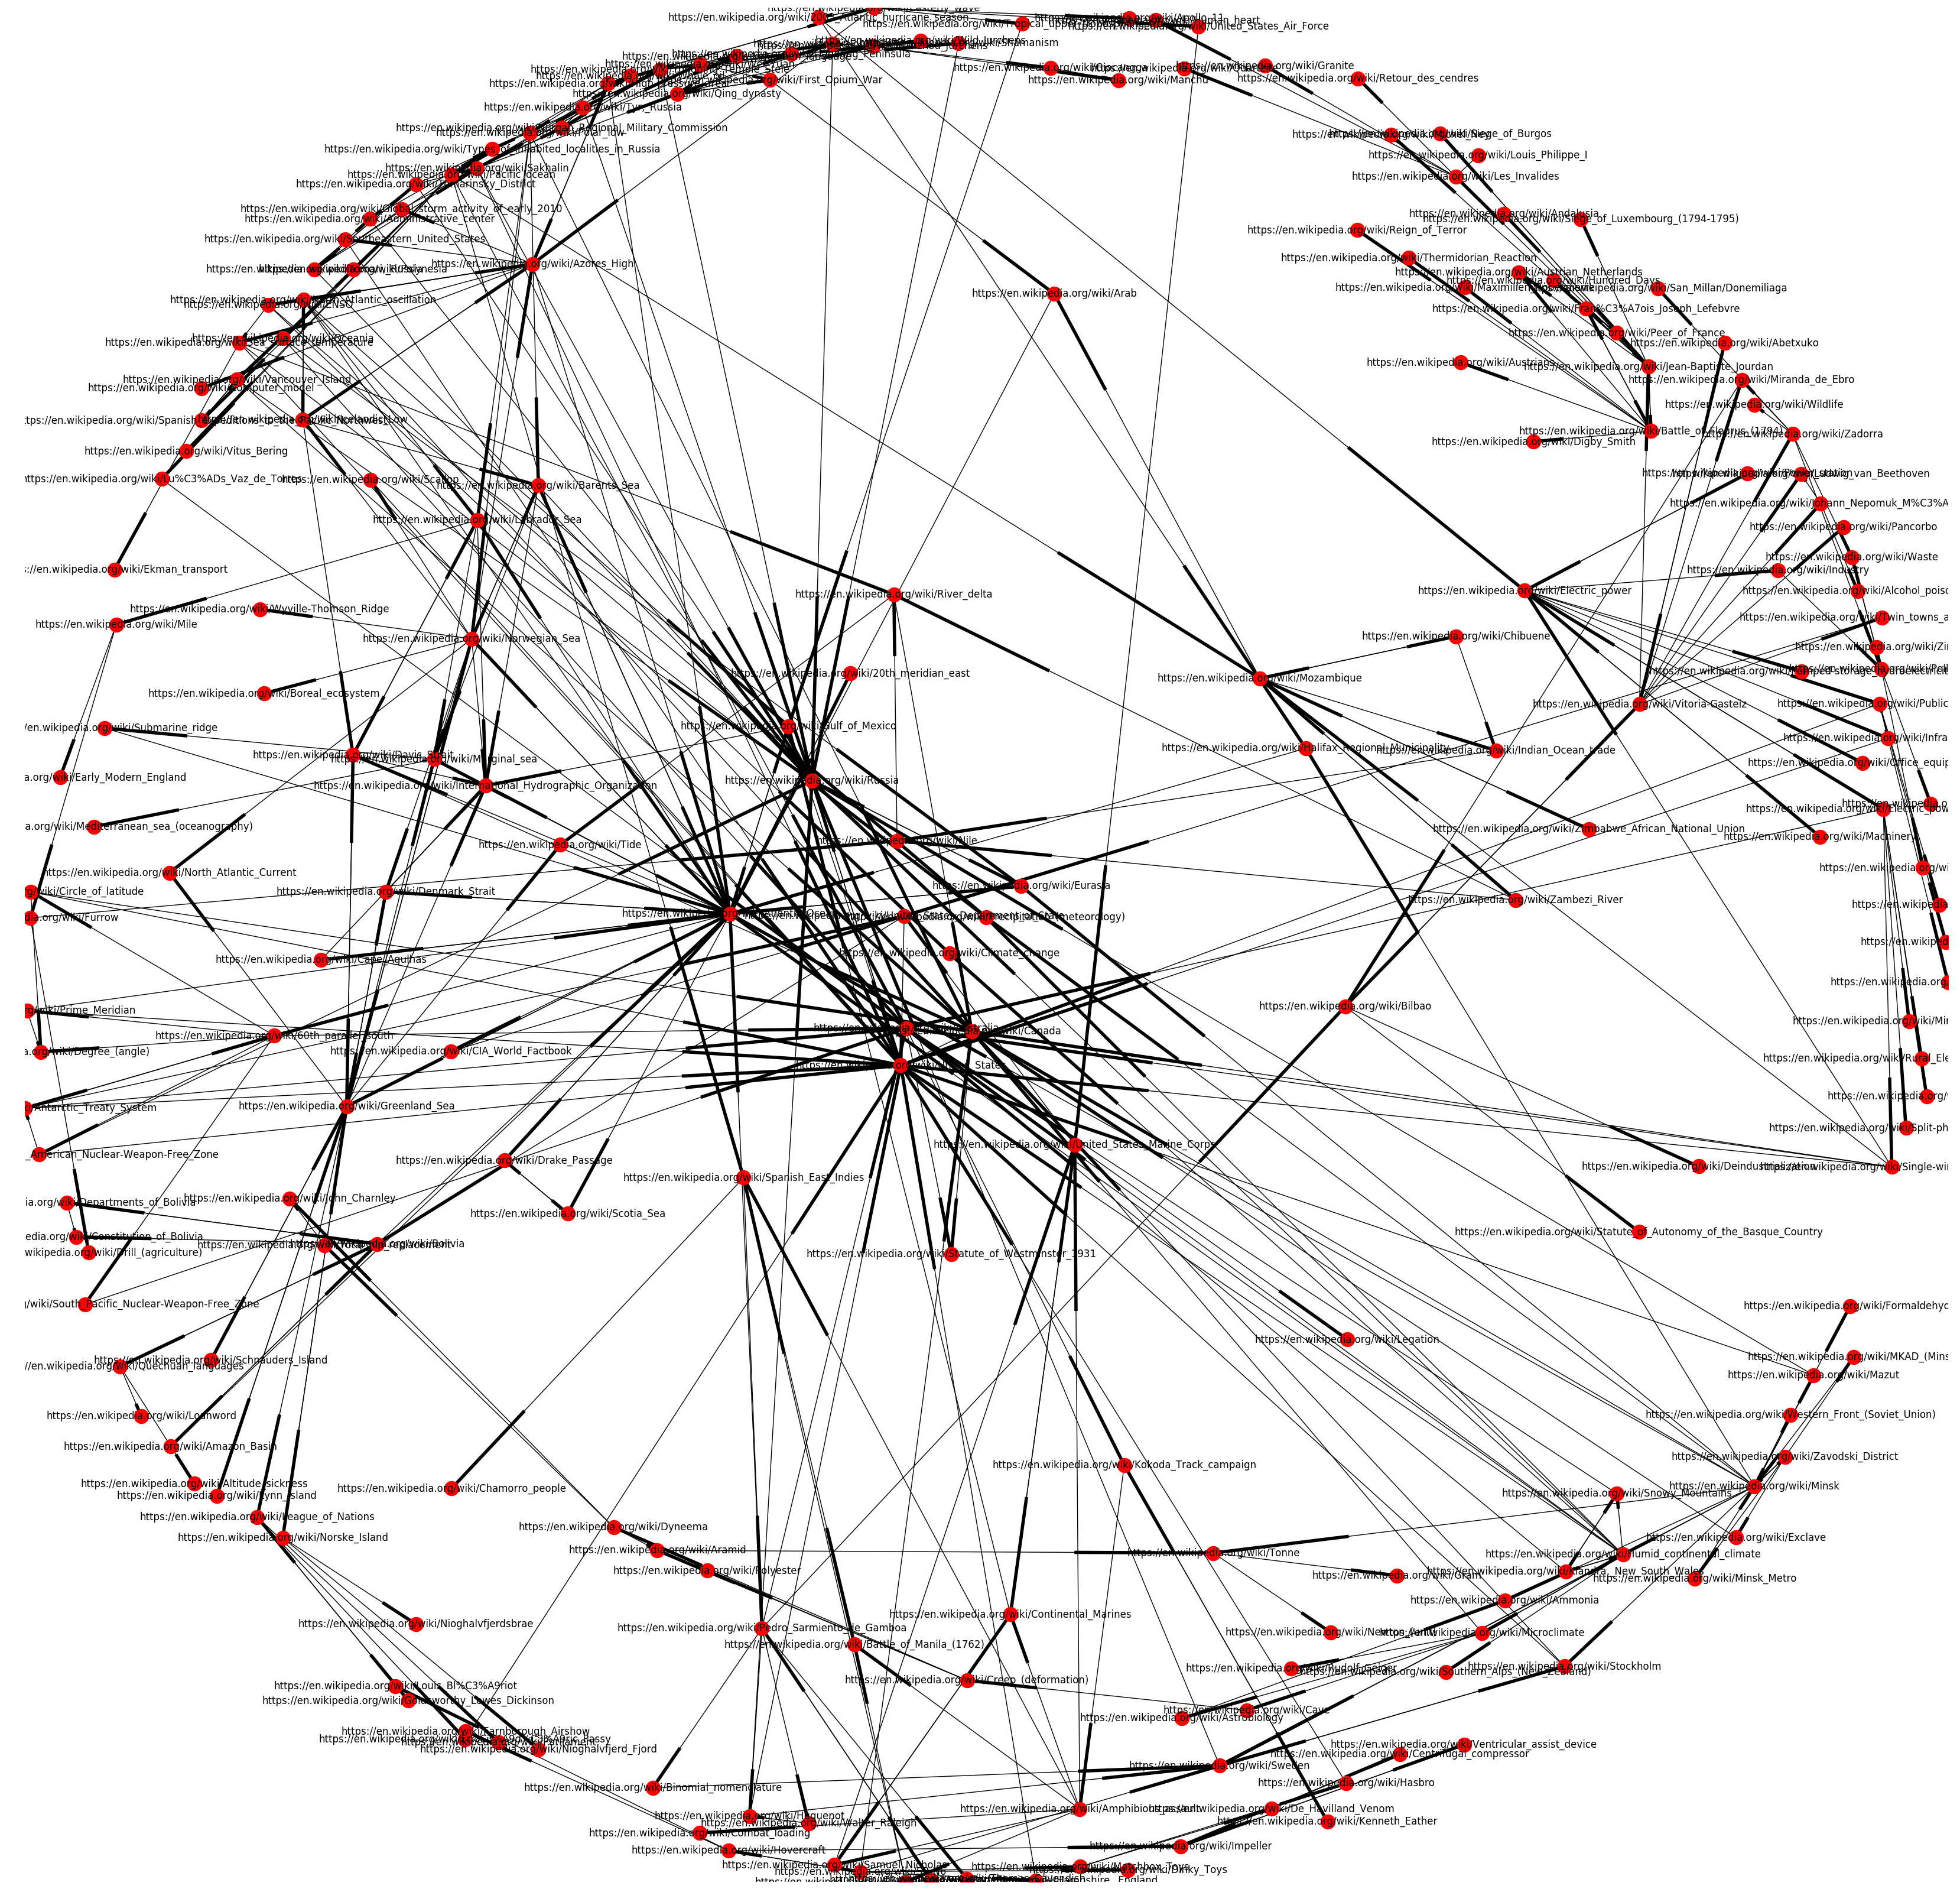

In [18]:
sample_graph = create_graph(main_df, 0.02)
def show_graph(graph): 

    plt.figure(num=None, figsize=(42, 42), dpi=100) 
    plt.axis('off') 
    fig = plt.figure(1) 
    pos = nx.spring_layout(graph) 
    nx.draw_networkx_nodes(graph,pos) 
    nx.draw_networkx_edges(graph,pos,arrows=True) 
    nx.draw_networkx_labels(graph,pos) 

    cut = 1
    xmax = cut * max(xx for xx, yy in pos.values()) 
    ymax = cut * max(yy for xx, yy in pos.values()) 
    plt.xlim(0, xmax) 
    plt.ylim(0, ymax) 
    plt.show()
    
show_graph(sample_graph)

Рассчет pageRank и вывод результатов:
возьмем топ 10 url по pageRank и сделаем inner join с основным датасетом

In [19]:
full_graph = create_graph(main_df)
def calculate_pageRank(graph, main_df, alpha=0.85):
    def pretty_print(df):
        for r in df.sort_values('pageRank', ascending=False).iterrows():
            print u'{0} {1}\n{2}\n{3}\n'.format(r[1]['title'],r[1]['pageRank'],r[1]['url'],r[1]['snippet'])
    pr = nx.pagerank(graph, alpha=alpha)
    pr_df = pd.DataFrame([(key, pr[key]) for key in sorted(pr, key=pr.get, reverse=True)][:10], columns=['url','pageRank'])
    result_df = pd.merge(main_df, pr_df, on='url')
    pretty_print(result_df)

number of nodes:  10001
number of edges:  22437


Результаты для различных alpha (0.85, 0.9, 0.5, 0.3)

In [20]:
calculate_pageRank(full_graph, main_df)

United States 0.0363150821108
https://en.wikipedia.org/wiki/United_States
Coordinates: 40°N 100°W﻿ / ﻿40°N 100°W﻿ / 40; -100...

Russia 0.0292533437934
https://en.wikipedia.org/wiki/Russia
Coordinates: 60°N 90°E﻿ / ﻿60°N 90°E﻿ / 60; 90...

Canada 0.0230215186594
https://en.wikipedia.org/wiki/Canada
Coordinates: 60°N 95°W﻿ / ﻿60°N 95°W﻿ / 60; -95...

Statute of Westminster 1931 0.0221677798062
https://en.wikipedia.org/wiki/Statute_of_Westminster_1931
The Statute of Westminster 1931 is an Act of the Parliament of the United Kingdom and modified versions of it are now domestic law within Australia and Canada; it has been repealed in New Zealand and implicitly in former Dominions that are no longer Commo...

Eurasia 0.013827553542
https://en.wikipedia.org/wiki/Eurasia
Eurasia /jʊˈreɪʒə/ is a combined continental landmass of Europe and Asia.[2][3][4] The term is a portmanteau of its constituent continents. Located primarily in the Northern and Eastern Hemispheres, it is bordered by the Atla

In [21]:
calculate_pageRank(full_graph, main_df, 0.9)

United States 0.038712816225
https://en.wikipedia.org/wiki/United_States
Coordinates: 40°N 100°W﻿ / ﻿40°N 100°W﻿ / 40; -100...

Russia 0.0331014574145
https://en.wikipedia.org/wiki/Russia
Coordinates: 60°N 90°E﻿ / ﻿60°N 90°E﻿ / 60; 90...

Statute of Westminster 1931 0.0253213948181
https://en.wikipedia.org/wiki/Statute_of_Westminster_1931
The Statute of Westminster 1931 is an Act of the Parliament of the United Kingdom and modified versions of it are now domestic law within Australia and Canada; it has been repealed in New Zealand and implicitly in former Dominions that are no longer Commo...

Canada 0.0251399416919
https://en.wikipedia.org/wiki/Canada
Coordinates: 60°N 95°W﻿ / ﻿60°N 95°W﻿ / 60; -95...

Eurasia 0.0165107650587
https://en.wikipedia.org/wiki/Eurasia
Eurasia /jʊˈreɪʒə/ is a combined continental landmass of Europe and Asia.[2][3][4] The term is a portmanteau of its constituent continents. Located primarily in the Northern and Eastern Hemispheres, it is bordered by the Atla

In [22]:
calculate_pageRank(full_graph, main_df, 0.5)

United States 0.019148027943
https://en.wikipedia.org/wiki/United_States
Coordinates: 40°N 100°W﻿ / ﻿40°N 100°W﻿ / 40; -100...

Russia 0.0102939168788
https://en.wikipedia.org/wiki/Russia
Coordinates: 60°N 90°E﻿ / ﻿60°N 90°E﻿ / 60; 90...

Canada 0.00999192040816
https://en.wikipedia.org/wiki/Canada
Coordinates: 60°N 95°W﻿ / ﻿60°N 95°W﻿ / 60; -95...

Statute of Westminster 1931 0.00607815723965
https://en.wikipedia.org/wiki/Statute_of_Westminster_1931
The Statute of Westminster 1931 is an Act of the Parliament of the United Kingdom and modified versions of it are now domestic law within Australia and Canada; it has been repealed in New Zealand and implicitly in former Dominions that are no longer Commo...

Australia 0.00400081178392
https://en.wikipedia.org/wiki/Australia
Coordinates: 27°S 133°E﻿ / ﻿27°S 133°E﻿ / -27; 133...

Sweden 0.00388428541177
https://en.wikipedia.org/wiki/Sweden
Coordinates: 63°N 16°E﻿ / ﻿63°N 16°E﻿ / 63; 16...

Eurasia 0.00300544515773
https://en.wikipedia.org/w

In [23]:
calculate_pageRank(full_graph, main_df, 0.3)

United States 0.0110837916861
https://en.wikipedia.org/wiki/United_States
Coordinates: 40°N 100°W﻿ / ﻿40°N 100°W﻿ / 40; -100...

Canada 0.00491512049452
https://en.wikipedia.org/wiki/Canada
Coordinates: 60°N 95°W﻿ / ﻿60°N 95°W﻿ / 60; -95...

Russia 0.00449034424018
https://en.wikipedia.org/wiki/Russia
Coordinates: 60°N 90°E﻿ / ﻿60°N 90°E﻿ / 60; 90...

Australia 0.00263473871675
https://en.wikipedia.org/wiki/Australia
Coordinates: 27°S 133°E﻿ / ﻿27°S 133°E﻿ / -27; 133...

Sweden 0.0022998954995
https://en.wikipedia.org/wiki/Sweden
Coordinates: 63°N 16°E﻿ / ﻿63°N 16°E﻿ / 63; 16...

Statute of Westminster 1931 0.00200622412323
https://en.wikipedia.org/wiki/Statute_of_Westminster_1931
The Statute of Westminster 1931 is an Act of the Parliament of the United Kingdom and modified versions of it are now domestic law within Australia and Canada; it has been repealed in New Zealand and implicitly in former Dominions that are no longer Commo...

Atlantic Ocean 0.00119645976923
https://en.wikiped

Видно, что для различных альфа результаты меняются, однако топ 3 списка остается неизменным